## How much tracer is there on the shelf?

This notebook explores the effects of changing the initial tracer profile on the total amount of tracer (mass) on the shelf at a certain time and place.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [4]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)

BARrun01 = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc'
StateOut01 = Dataset(BARrun01)

TRArun01 = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
PtracersOut01 = Dataset(TRArun01)



In [5]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

rc = CGridOut.variables['RC']
xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
dxG = rout.getField(CGrid,'dxG')

MaskCan = rout.getMask(CGrid,'HFacC') 
hFacCCan = rout.getField(CGrid,'HFacC') 
rACan = rout.getField(CGrid,'rA') 
drFCan= CGridOut.variables['drF']


In [6]:
# Load tracers 
Tr1 = rout.getField(TRArun01,'Tr01')
Tr2 = rout.getField(TRArun01,'Tr02') 
Tr3 = rout.getField(TRArun01,'Tr03') 
Tr4 = rout.getField(TRArun01,'Tr04') 


In [7]:
Tr5 = rout.getField(TRArun01,'Tr05') 
Tr6 = rout.getField(TRArun01,'Tr06') 
Tr7 = rout.getField(TRArun01,'Tr07') 
Tr8 = rout.getField(TRArun01,'Tr08') 


### How much water with concentration higher than a limit is there on the shelf at each time? How much tracer mass?

In [8]:
def HowMuchWaterX(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [:,:30,227:,:] at every time output.
    Total_Tracer =  Array with the mass of tracer (Mol) at each x-position over the shelf [:,:30,227:,:] at every time output.
          Total mass of tracer at xx on the shelf.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    mask_expand = np.expand_dims(MaskC,0)
    mask_expand = mask_expand + np.zeros(Tr.shape)

    TrMask0=np.ma.array(Tr[0,:,:,:],mask=mask_expand[0,:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    print('tracer limit is: ',trlim)
    
    TrMask=np.ma.array(Tr,mask=mask_expand)
    
    WaterX = 0
    
    # Make mask for cells with tracer concentration >= trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    
    
    
    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1),axis=1) 
    # 1 m^3 = 1000 l
    
    return (VolWaterHighConc, Total_Tracer)

### Calculate volume on shelf of high tracer concentration water and tracer mass. 

In [9]:


(WatTr1, TrMassTr1) = HowMuchWaterX(Tr1,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr2, TrMassTr2) = HowMuchWaterX(Tr2,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr3, TrMassTr3) = HowMuchWaterX(Tr3,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr4, TrMassTr4) = HowMuchWaterX(Tr4,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr5, TrMassTr5) = HowMuchWaterX(Tr5,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr6, TrMassTr6) = HowMuchWaterX(Tr6,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr7, TrMassTr7) = HowMuchWaterX(Tr7,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr8, TrMassTr8) = HowMuchWaterX(Tr8,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
      
    
   

('tracer limit is: ', 32.251045)
('tracer limit is: ', 33.898914)
('tracer limit is: ', 103.13976)
('tracer limit is: ', 32.763577)
('tracer limit is: ', 47.862217)
('tracer limit is: ', 2.2521822)
('tracer limit is: ', 27.700876)
('tracer limit is: ', 19.381783)


In [10]:
#Tr1max = np.max(Tr)

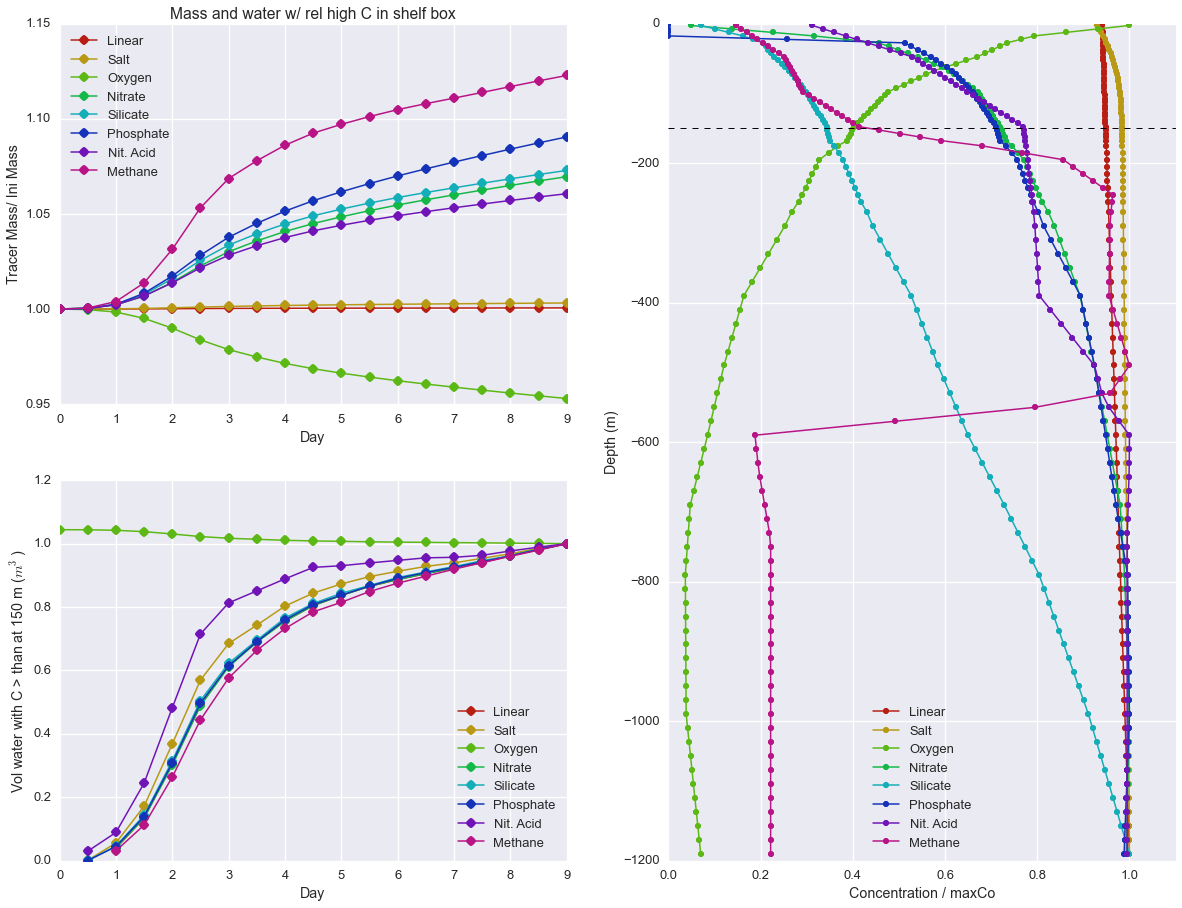

In [54]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    ax1 = plt.subplot(2,2,1)

    line1 = ax1.plot(times/2.0, TrMassTr1/TrMassTr1[0],'o-', label='Linear')
    line2 = ax1.plot(times/2.0, TrMassTr2/TrMassTr2[0],'o-', label='Salt')
    line3 = ax1.plot(times/2.0, TrMassTr3/TrMassTr3[0],'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, TrMassTr4/TrMassTr4[0],'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, TrMassTr5/TrMassTr5[0],'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, TrMassTr6/TrMassTr6[0],'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, TrMassTr7/TrMassTr7[0],'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, TrMassTr8/TrMassTr8[0],'o-', label='Methane')

    plt.ylabel('Tracer Mass/ Ini Mass ')
    plt.xlabel('Day')
    plt.title('Mass and water w/ rel high C in shelf box')
with sns.hls_palette(8, l=.4, s=.8):
    ax2 = plt.subplot(2,2,3)

    line1 = ax2.plot(times/2.0, WatTr1/WatTr1[len(WatTr1)-1],'o-',label='Linear')
    line2 = ax2.plot(times/2.0, WatTr2/WatTr2[len(WatTr2)-1],'o-', label='Salt')
    line3 = ax2.plot(times/2.0, WatTr3/WatTr3[len(WatTr3)-1],'o-', label='Oxygen')
    line4 = ax2.plot(times/2.0, WatTr4/WatTr4[len(WatTr4)-1],'o-', label='Nitrate')
    line5 = ax2.plot(times/2.0, WatTr5/WatTr5[len(WatTr5)-1],'o-', label='Silicate')
    line6 = ax2.plot(times/2.0, WatTr6/WatTr6[len(WatTr6)-1],'o-', label='Phosphate')
    line7 = ax2.plot(times/2.0, WatTr7/WatTr7[len(WatTr7)-1],'o-', label='Nit. Acid')
    line8 = ax2.plot(times/2.0, WatTr8/WatTr8[len(WatTr8)-1],'o-', label='Methane')
    
    plt.title('Relative volume water w/ rel high C in shelf box')
    plt.ylabel('Vol water with C > than at 150 m ($m^3$)')
    plt.xlabel('Day')
 
with sns.hls_palette(8, l=.4, s=.8):
    ax3 = plt.subplot(2,2,(2,4))

    line1 = ax3.plot(Tr1[0,:,50,180]/np.max(Tr1[0,:,50,180]),rc[:],'o-',markersize = 6, label='Linear')
    line2 = ax3.plot(Tr2[0,:,50,180]/np.max(Tr2[0,:,50,180]),rc[:],'o-',markersize = 6, label='Salt')
    line3 = ax3.plot(Tr3[0,:,50,180]/np.max(Tr3[0,:,50,180]),rc[:],'o-',markersize = 6, label='Oxygen')
    line4 = ax3.plot(Tr4[0,:,50,180]/np.max(Tr4[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nitrate')
    line5 = ax3.plot(Tr5[0,:,50,180]/np.max(Tr5[0,:,50,180]),rc[:],'o-',markersize = 6, label='Silicate')
    line6 = ax3.plot(Tr6[0,:,50,180]/np.max(Tr6[0,:,50,180]),rc[:],'o-',markersize = 6, label='Phosphate')
    line7 = ax3.plot(Tr7[0,:,50,180]/np.max(Tr7[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nit. Acid')
    line8 = ax3.plot(Tr8[0,:,50,180]/np.max(Tr8[0,:,50,180]),rc[:],'o-',markersize = 6, label='Methane')
    
    ax3.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
 
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        
